In [1]:
# %load_ext autoreload
# %autoreload 2
%matplotlib inline

In [2]:
from branchynet.net import BranchyNet
from branchynet.links import *
import chainer.functions as F
import chainer.links as L
from branchynet import utils, visualize
from chainer import cuda

Define Network

In [3]:
from networks import resnet_cifar10

branchyNet = resnet_cifar10.get_network()
branchyNet.to_gpu()
branchyNet.training()

Import Data

In [4]:
from datasets import pcifar10

x_train, y_train, x_test, y_test = pcifar10.get_data()

Settings

In [5]:
TRAIN_BATCHSIZE = 128
TEST_BATCHSIZE = 1
TRAIN_NUM_EPOCHS = 100

Train Main Network

In [6]:
main_loss, main_acc, main_time = utils.train(branchyNet, x_train, y_train, main=True, batchsize=TRAIN_BATCHSIZE,
                                             num_epoch=TRAIN_NUM_EPOCHS)

Train BranchyNet

In [7]:
TRAIN_NUM_EPOCHS = 100
branch_loss, branch_acc, branch_time = utils.train(branchyNet, x_train, y_train, batchsize=TRAIN_BATCHSIZE,
                                                   num_epoch=TRAIN_NUM_EPOCHS)

#set network to inference mode
branchyNet.testing()

Visualizing Network Training

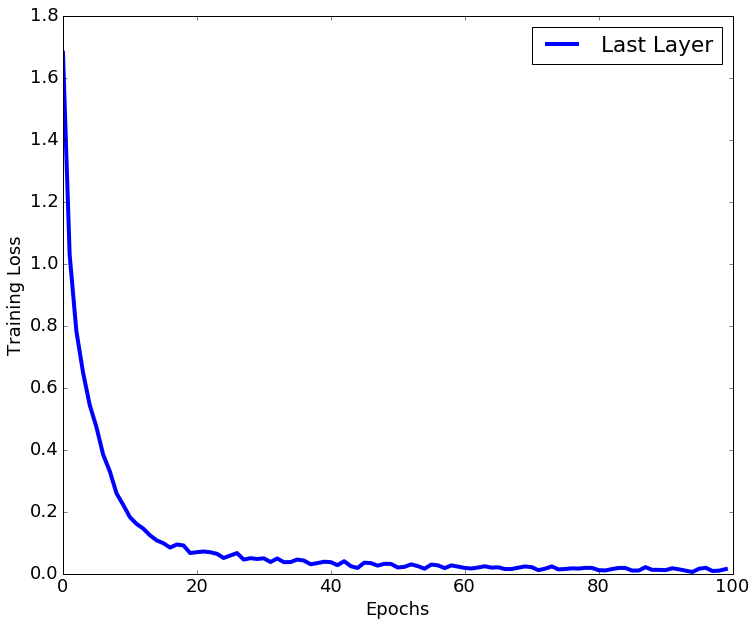

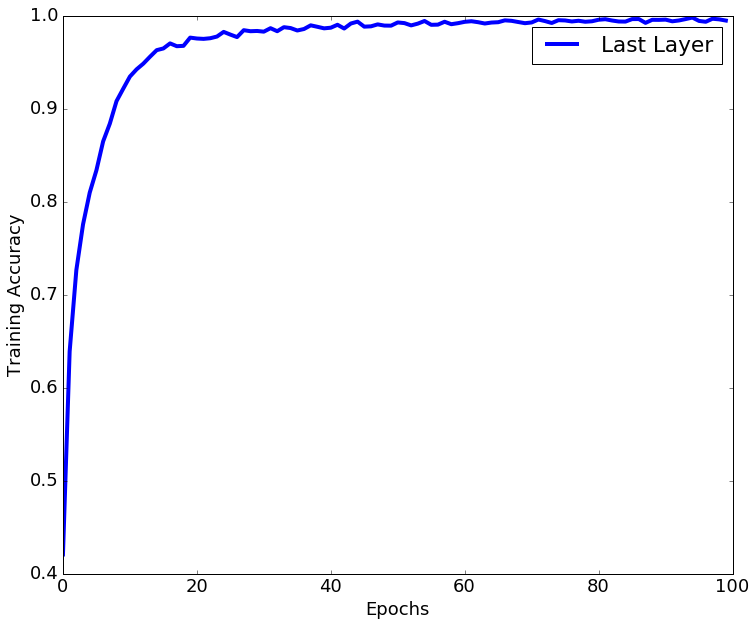

In [8]:
visualize.plot_layers(main_loss, xlabel='Epochs', ylabel='Training Loss')
visualize.plot_layers(main_acc, xlabel='Epochs', ylabel='Training Accuracy')

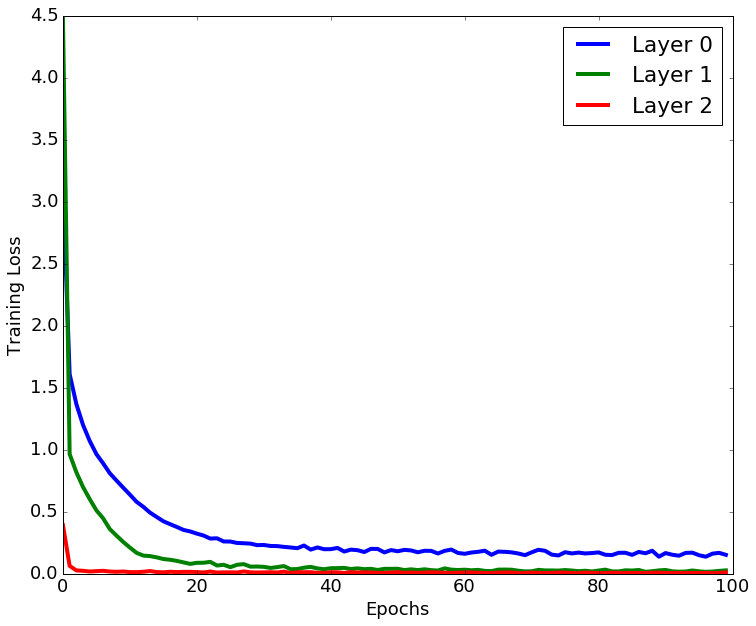

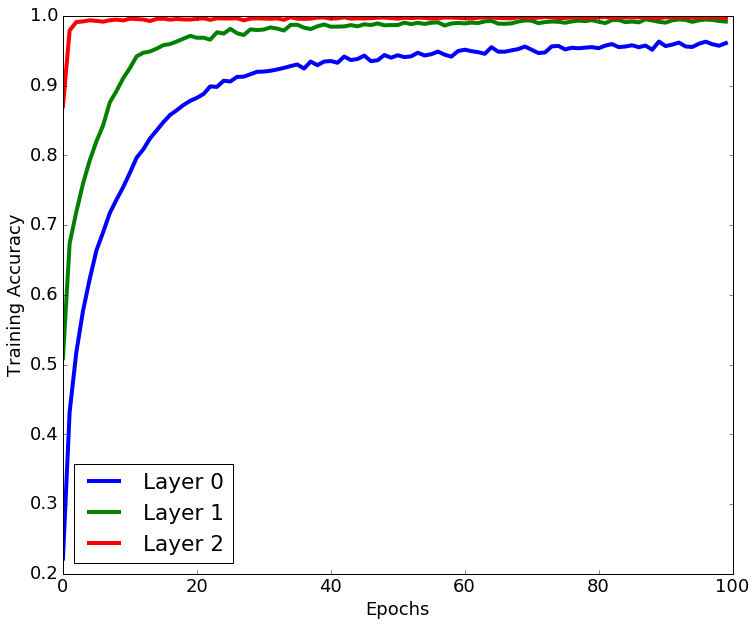

In [9]:
visualize.plot_layers(zip(*branch_loss), xlabel='Epochs', ylabel='Training Loss')
visualize.plot_layers(zip(*branch_acc), xlabel='Epochs', ylabel='Training Accuracy')

Run test suite and visualize

In [10]:
#set network to inference mode
branchyNet.testing()
branchyNet.verbose = False
branchyNet.to_gpu()
g_baseacc, g_basediff, _, _ = utils.test(branchyNet,x_test,y_test,main=True,batchsize=TEST_BATCHSIZE)
g_basediff = (g_basediff / float(len(y_test))) * 1000.

#branchyNet.to_cpu()
c_baseacc, c_basediff, _, _ = utils.test(branchyNet,x_test,y_test,main=True,batchsize=TEST_BATCHSIZE)
c_basediff = (c_basediff / float(len(y_test))) * 1000.

In [ ]:
# Specify thresholds
thresholds = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1., 2., 3., 5., 10.]

In [ ]:
#GPU
branchyNet.to_gpu()
g_ts, g_accs, g_diffs, g_exits = utils.screen_branchy(branchyNet, x_test, y_test, thresholds,
                                                    batchsize=TEST_BATCHSIZE, verbose=True)


#convert to ms
g_diffs *= 1000.

In [ ]:
visualize.plot_line_tradeoff(g_accs, g_diffs, g_ts, g_exits, g_baseacc, g_basediff, all_samples=False, inc_amt=-0.0001000,
                             our_label='BranchyResNet', orig_label='ResNet', xlabel='Runtime (ms)', 
                             title='ResNet GPU', output_path='_figs/resnet_gpu.pdf')

In [ ]:
#CPU
branchyNet.to_cpu()
c_ts, c_accs, c_diffs, c_exits  = utils.screen_branchy(branchyNet, x_test, y_test, thresholds,
                                                     batchsize=TEST_BATCHSIZE, verbose=True)

#convert to ms
c_diffs *= 1000.

In [ ]:
visualize.plot_line_tradeoff(c_accs, c_diffs, c_ts, c_exits, c_baseacc, c_basediff, all_samples=False, inc_amt=-0.0001000,
                             our_label='BranchyResNet', orig_label='ResNet', xlabel='Runtime (ms)',
                             title='ResNet CPU', output_path='_figs/resnet_cpu.pdf')

In [ ]:
print 'CPU Results:'
utils.branchy_table_results('ResNet', c_baseacc, c_basediff, c_accs, c_diffs, c_exits, c_ts)

print '\n\n'

print 'GPU Results:'
utils.branchy_table_results('ResNet', g_baseacc, g_basediff, g_accs, c_diffs, g_exits, g_ts)

Save model/data

In [ ]:
import dill
branchyNet.to_cpu()
with open("_models/resnet_cifar10.bn", "wb") as f:
    dill.dump(branchyNet, f)
with open("_models/resnet_cifar10_gpu_results.pkl", "wb") as f:
    dill.dump({'accs': g_accs, 'rt': g_diffs, 'exits': g_exits, 'ts': g_ts, 'baseacc': g_baseacc, 'basediff': g_basediff}, f)
with open("_models/resnet_cifar10_cpu_results.pkl", "wb") as f:
    dill.dump({'accs': c_accs, 'rt': c_diffs, 'exits': c_exits, 'ts': c_ts, 'baseacc': c_baseacc, 'basediff': c_basediff}, f)